# Sparse Matrix Factorizations and Fill-In

In [1]:
import numpy as np
import scipy.linalg as la

import matplotlib.pyplot as pt

import random

Here's a helper routine to make a random **symmetric** sparse matrix:

In [2]:
def make_random_sparse_matrix(n, row_fill):
    nentries = (n*row_fill) // 2 # because of symmetry
    data = np.random.randn(nentries)
    rows = np.random.randint(0, n-1, nentries)
    cols = np.random.randint(0, n-1, nentries)
    
    import scipy.sparse as sps
    
    coo = sps.coo_matrix((data, (rows, cols)), shape=(n,n))
    
    # NOTE: Cuthill-McKee applies only to symmetric matrices!
    return (100*np.eye(n) + np.array(coo.todense() +  coo.todense().T))

Next, we will take a look at that matrix from a "birds eye view". Every entry with absolute value greater that $10^{-10}$ will show up as a 'dot':

794 non-zeros


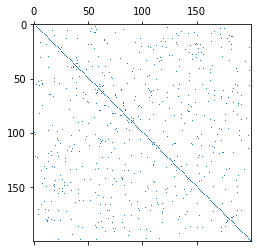

In [3]:
prec = 1e-10

np.random.seed(15)
random.seed(15)

A = make_random_sparse_matrix(200, 3)
print("%d non-zeros" % len(np.where(np.abs(A)>prec)[0]))
pt.figure()
pt.spy(A, marker=",", precision=prec)

Next, let's apply the same visualization to the inverse:

7148 non-zeros


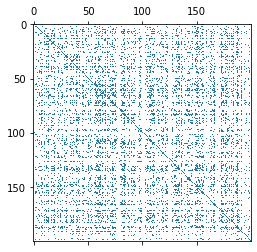

In [4]:
Ainv = la.inv(A)
print("%d non-zeros" % len(np.where(np.abs(Ainv) > prec)[0]))
pt.spy(Ainv, marker=",", precision=prec)

And the Cholesky factorization:

1819 non-zeros


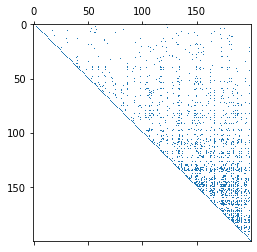

In [5]:
L = la.cholesky(A)
print("%d non-zeros" % len(np.where(np.abs(L) > prec)[0]))
pt.spy(L, marker=",", precision=prec)

Cholesky is often less bad, but in principle affected the same way.

## Reducing the fill-in

Define the *degree* of a row as the number of non-zeros in it.

In [6]:
def degree(mat, row):
    return len(np.where(mat[row])[0])

print(degree(A, 3))
print(degree(A, 4))
print(degree(A, 5))

2
4
3


Then find an ordering so that all the low degrees come first.

The [Cuthill-McKee algorithm](https://en.wikipedia.org/wiki/Cuthill%E2%80%93McKee_algorithm) is a greedy algorithm to find such an ordering:

In [7]:
def argmin2(iterable, return_value=False):
    it = iter(iterable)
    try:
        current_argmin, current_min = next(it)
    except StopIteration:
        raise ValueError("argmin of empty iterable")

    for arg, item in it:
        if item < current_min:
            current_argmin = arg
            current_min = item

    if return_value:
        return current_argmin, current_min
    else:
        return current_argmin

def argmin(iterable):
    return argmin2(enumerate(iterable))

In [8]:
def cuthill_mckee(mat):
    """Return a Cuthill-McKee ordering for the given matrix.

    See (for example)
    Y. Saad, Iterative Methods for Sparse Linear System,
    2nd edition, p. 76.
    """

    # this list is called "old_numbers" because it maps a
    # "new number to its "old number"
    old_numbers = []
    visited_nodes = set()
    levelset = []

    all_nodes = set(range(len(mat)))

    while len(old_numbers) < len(mat):
        if not levelset:
            unvisited = list(all_nodes - visited_nodes)

            if not unvisited:
                break

            start_node = unvisited[
                    argmin(degree(mat, node) for node in unvisited)]
            visited_nodes.add(start_node)
            old_numbers.append(start_node)
            levelset = [start_node]

        next_levelset = set()
        levelset.sort(key=lambda row: degree(mat, row))
        #print(levelset)
        
        for node in levelset:
            row = mat[node]
            neighbors, = np.where(row)
            
            for neighbor in neighbors:
                if neighbor in visited_nodes:
                    continue

                visited_nodes.add(neighbor)
                next_levelset.add(neighbor)
                old_numbers.append(neighbor)

        levelset = list(next_levelset)

    return np.array(old_numbers, dtype=np.intp)

In [9]:
cmk = cuthill_mckee(A)

Someone (empirically) observed that the *reverse* of the Cuthill-McKee ordering often does better than forward Cuthill-McKee.

So construct a permutation matrix corresponding to that:

In [10]:
P = np.eye(len(A))[cmk[::-1]]

And then reorder both rows and columns according to that--a similarity transform:

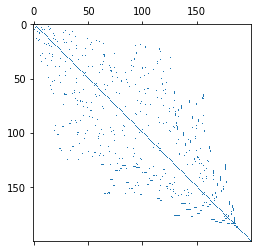

In [11]:
A_reordered = P @ A @ P.T

pt.spy(A_reordered, marker=",", precision=prec)

Next, let's try Cholesky again:

1188 non-zeros


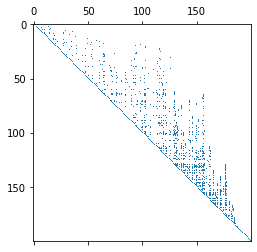

In [12]:
L = la.cholesky(A_reordered)
print("%d non-zeros" % len(np.where(np.abs(L) > prec)[0]))
pt.spy(L, marker=",", precision=prec)